In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
!pip install collection
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, WordPunctTokenizer, word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
import string, re, os, warnings
#from collections import Collection, Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable


In [2]:
df = pd.read_csv('airline.csv')
df.sample(5)

,Air_ailine
809,✅Trip Verified| Gatwick to Tirana. I was incr...
3694,10th July BA117 LHR-JFK. Well I have not flown...
3019,"Recently flew BA from LHR to ORD, 64A, Upper D..."
3295,Flew AMS-LHR-JFK return 26th Dec - 31st Dec. A...
1808,❎Unverified| London to Reykjavik. I can't rea...


In [3]:
df['Air_ailine'][:1]

0    Not Verified|  My wife and I are very disappoi...
Name: Air_ailine, dtype: object

In [4]:
df.shape, df.dtypes, df.isnull().sum()

((3861, 1),
 Air_ailine    object
 dtype: object,
 Air_ailine    0
 dtype: int64)

In [5]:
### longueur des commentaires
def length_text(text):
    text = text.split(" ")
    long = len(text)
    return long

df['length_avis'] = df['Air_ailine'].apply(lambda i : length_text(i))
df.sample(10).max()

Air_ailine     ❎Not Verified| London to Olbia. Complete confu...
length_avis                                                  362
dtype: object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length_avis,3861.0,163.085729,107.257511,15.0,87.0,135.0,206.0,657.0


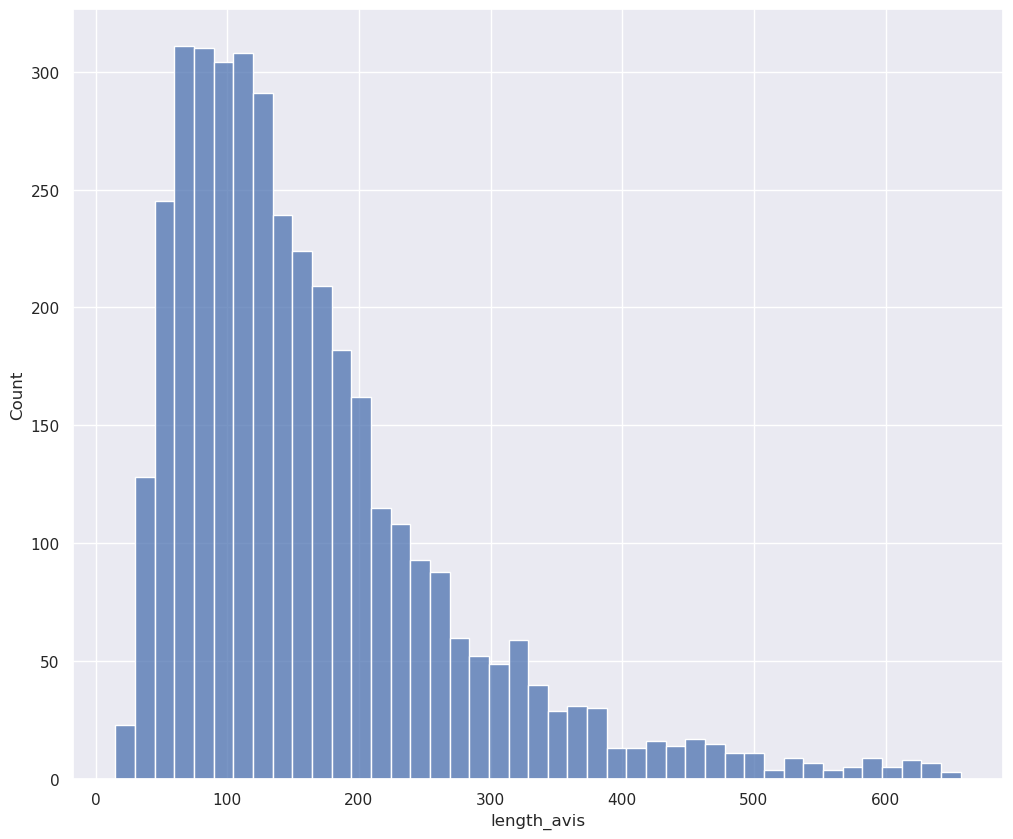

In [7]:
sns.set()
plt.figure(figsize = (12, 10))
sns.histplot(data = df, x = df['length_avis'])
plt.show()

# Pré-traitement des avis 

### Nettoyage des urls , emojis, caractères speciaux, des lien htmls etc...

In [8]:
def clean_text(text):
    ### normaliser la tailles des textes
    text = text.lower()
    ## suppression des caracteres speciaux et autres 
    text = re.sub("\[.*?\]", '', text)
    #supprimer les urls html, asc
    text = re.sub("https?://\S+|www\.\S+", '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub("\n", '', text)
    text = re.sub('\w*\d\w*', '', text)
    #text = re.sub('\w*\d\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['airline_clean'] = df['Air_ailine'].apply(lambda x: clean_text(x))
df.sample(n = 10)

,Air_ailine,length_avis,airline_clean
662,Not Verified| What has happened to British Ai...,538,not verified what has happened to british air...
1087,✅Trip Verified| Madrid to London BA0457 on th...,80,✅trip verified madrid to london on the coul...
793,✅Trip Verified| I purchased roundtrip tickets ...,101,✅trip verified i purchased roundtrip tickets f...
1091,✅Trip Verified| I had a miserable experience ...,114,✅trip verified i had a miserable experience i...
2699,I think one word sums it up 'Rubbish'. The Lon...,377,i think one word sums it up rubbish the london...
197,Not Verified| Awful. Business class check in ...,86,not verified awful business class check in qu...
1039,✅Trip Verified| Lima to Gatwick. Helpful and ...,81,✅trip verified lima to gatwick helpful and co...
1662,✅Verified Review| Nice to London Heathrow. Yo...,215,✅verified review nice to london heathrow you ...
2659,MAD-SYD VIA LHR with British Airways. Overall ...,63,madsyd via lhr with british airways overall go...
2031,✅Verified Review| Flew from Gatwick to Tampa ...,261,✅verified review flew from gatwick to tampa b...


In [9]:
def text_clean(text):
    text = text.lower()
    # Ne garde que les caractères alphanumériques, espaces et ponctuation
    text = re.sub(r'[^\w\s,.!?]', '', text)  

    # Suppression des parties 'Trip Verified' ou 'Not Verified'
    text = re.sub(r'(Trip Verified|Verified Review|Not Verified|Unverified)', '',text, flags=re.IGNORECASE).strip()
    text = re.sub("\[.*?\]", '', text)
    #supprimer les urls html, asc
    text = re.sub("https?://\S+|www\.\S+", '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub("\n", '', text)
    text = re.sub('\w*\d\w*', '', text)
    #text = re.sub('\w*\d\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text_clean'] = df['Air_ailine'].apply(text_clean)
df.sample(20)

,Air_ailine,length_avis,airline_clean,text_clean
717,✅Trip Verified| I was supposed to fly with Ae...,567,✅trip verified i was supposed to fly with aer...,i was supposed to fly with aeroflot on the of...
2192,✅Verified Review| British Airways was the che...,49,✅verified review british airways was the chea...,british airways was the cheapest airline when ...
748,✅Trip Verified| Just before the borders were c...,251,✅trip verified just before the borders were cl...,just before the borders were closed in south a...
2701,London Heathrow to Brisbane via Singapore retu...,112,london heathrow to brisbane via singapore retu...,london heathrow to brisbane via singapore retu...
192,✅Trip Verified| The worst airline I have eve...,65,✅trip verified the worst airline i have ever...,the worst airline i have ever flown with alloc...
1560,✅Verified Review| London to New York JFK in c...,147,✅verified review london to new york jfk in cl...,london to new york jfk in club world after rea...
2694,Flew to Kuala Lumpur with British Airways on a...,150,flew to kuala lumpur with british airways on a...,flew to kuala lumpur with british airways on a...
935,✅Trip Verified| London to Abu Dhabi. This is ...,115,✅trip verified london to abu dhabi this is th...,london to abu dhabi this is the daytime flight...
743,✅Trip Verified| My wife and I used Avios and ...,157,✅trip verified my wife and i used avios and m...,my wife and i used avios and my ba amex compan...
1340,Not Verified| First time flying with British ...,124,not verified first time flying with british a...,first time flying with british airways in econ...


### WordCloud of text avis 

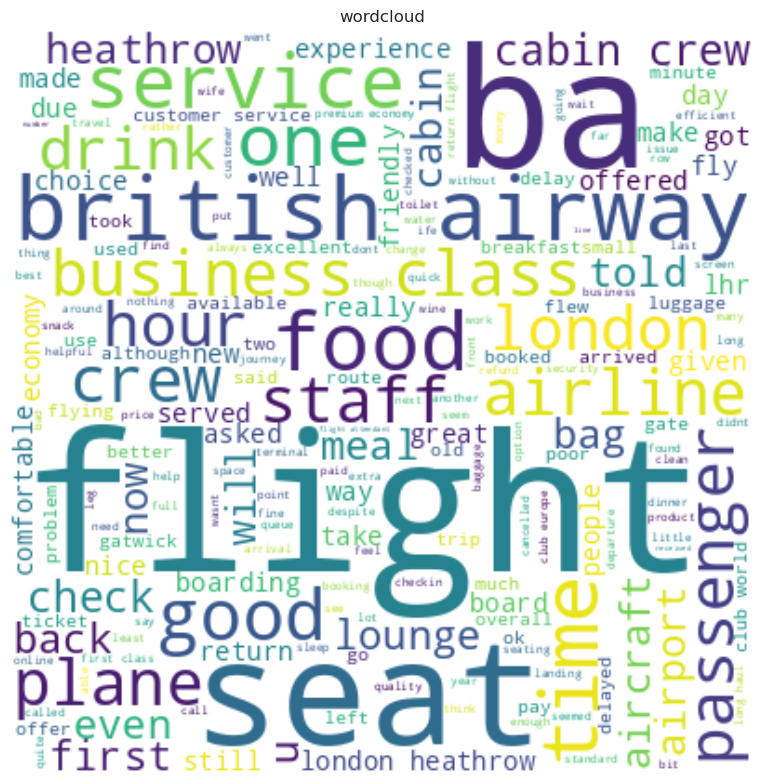

In [10]:
def get_wordcloud(text):
    text = ' '.join(text)
    word = WordCloud(width = 400, height = 400, background_color = 'white').generate(text)
    plt.figure(figsize=(12, 8))
    plt.imshow(word, interpolation='bilinear')
    plt.axis('off')
    plt.title("wordcloud")
    plt.tight_layout()
    plt.show()

get_wordcloud(df['text_clean'])

In [11]:
##Analysis sentiment of each reviews person trip

def sentiment_analysis(text):
    sentiment  = SentimentIntensityAnalyzer()
    score = sentiment.polarity_scores(text)

    if score['compound'] > 0.05:
        return 'positif'
    elif score['compound'] <-0.05:
        return 'negative'
    else:
        return 'neutre'

df['sentiment'] = df['text_clean'].apply(sentiment_analysis)
df.sample(5)

,Air_ailine,length_avis,airline_clean,text_clean,sentiment
2812,"British Airways from London to Rome, almost pe...",38,british airways from london to rome almost per...,british airways from london to rome almost per...,positif
3435,Recently flew with British Airways on Europe t...,69,recently flew with british airways on europe t...,recently flew with british airways on europe t...,negative
544,"✅Trip Verified| When I tried to check in, the...",265,✅trip verified when i tried to check in they ...,when i tried to check in they required a certi...,negative
1687,✅Verified Review| \r\nFlew British Airways fr...,296,✅verified review \rflew british airways from ...,flew british airways from pisa to london gatwi...,positif
3534,Flown 6 flights on BA recently generally satis...,165,flown flights on ba recently generally satisf...,flown flights on ba recently generally satisf...,positif


In [12]:
df.sentiment.value_counts().reset_index()

,sentiment,count
0,positif,2203
1,negative,1598
2,neutre,60


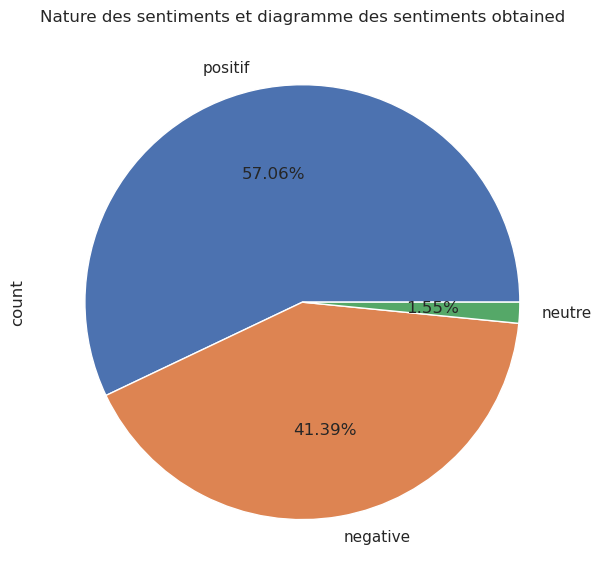

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(8, 6))
df.sentiment.value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.title('Nature des sentiments et diagramme des sentiments obtained')
plt.tight_layout()
sns.set_style('white')
plt.show()
plt.savefig('circulaire_sentiment.png', format = 'png', dpi = 300)

## Visualisations des sentiments positif, negative ou neutre

Nuage de point des sentiments positive


<Figure size 640x480 with 0 Axes>

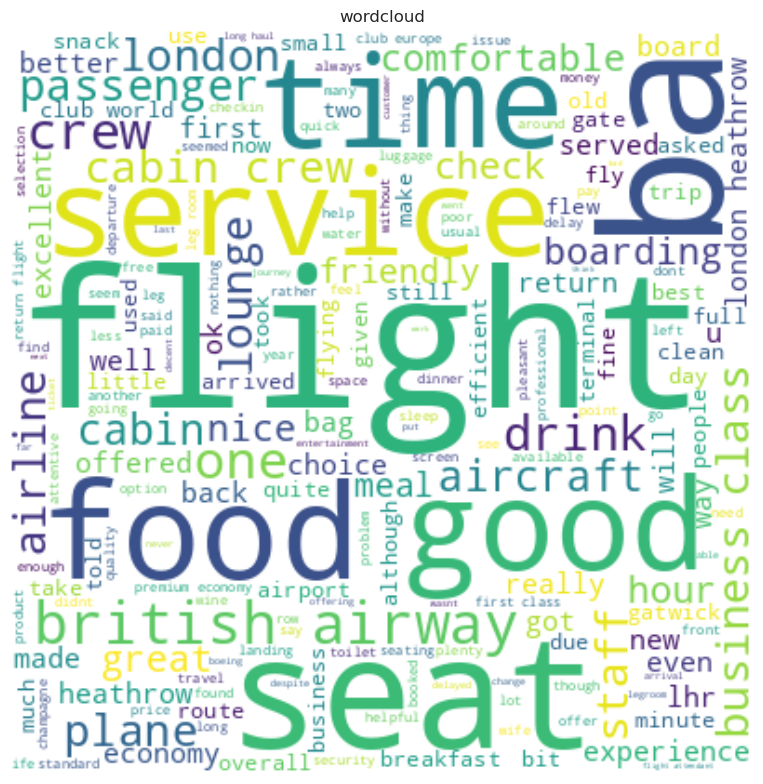

Nuage de point des sentiments negative


<Figure size 640x480 with 0 Axes>

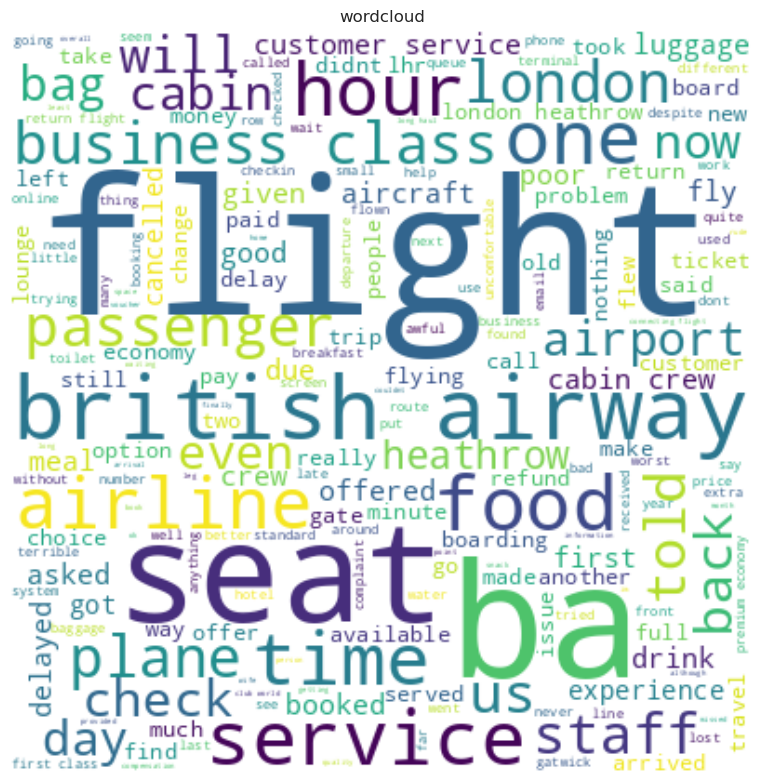

Nuage de point des sentiments neutre


<Figure size 640x480 with 0 Axes>

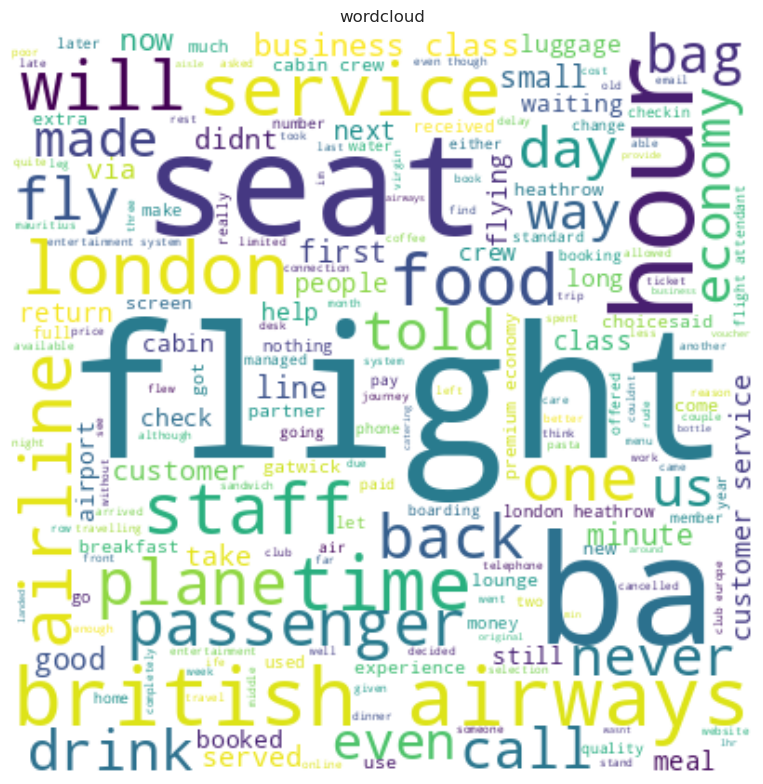

In [14]:
positive = df.loc[df['sentiment'] == 'positif', 'text_clean']
negative = df.loc[df['sentiment'] == 'negative', 'text_clean']
neutre = df.loc[df['sentiment'] == 'neutre', 'text_clean']

sentiment = [('positive', positive), ('negative', negative), 
             ('neutre', neutre)]
for label,feel in sentiment : 
    print(f"Nuage de point des sentiments {label}")
    plt.savefig('Nuage de points de {label}.png', format ='png', dpi = 300)
    get_wordcloud(feel)

In [15]:
positive

1       we flew ba between heathrow and berlin one way...
3       took a trip to nashville with my wife for a le...
6       as someone who flies relentlessly with british...
8       straightforward check in  new site for club ch...
12      although all four flights were delayed the ser...
                              ...                        
3856    lhrhkg on boeing    much has been written abou...
3857    lhr to ham purser addresses all club passenger...
3858    my son who had worked for british airways urge...
3859    london citynew york jfk via shannon on  but ha...
3860    sinlhr   first class old aircraft  with seats ...
Name: text_clean, Length: 2203, dtype: object

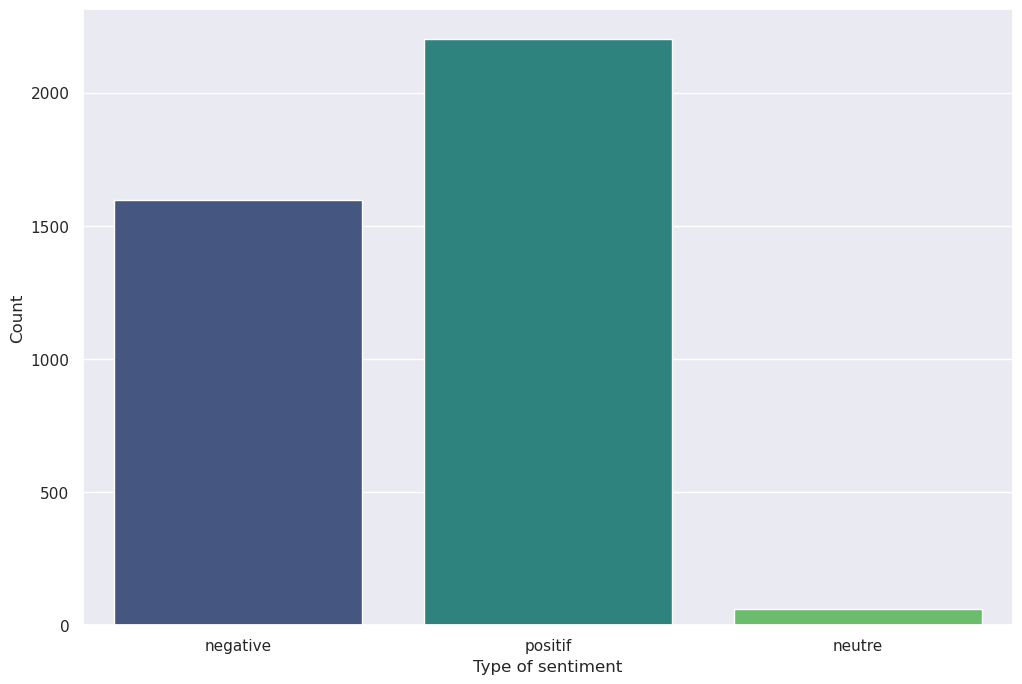

In [16]:
plt.figure(figsize=(12, 8))
sns.set()
sns.countplot(data = df, x = 'sentiment', palette = 'viridis')
sns.set_color_codes()
sns.set_style('white')
plt.xlabel('Type of sentiment')
plt.ylabel('Count')

plt.savefig(f"Diagramme.png", format = 'png', dpi = 300)
plt.show()

## Analyse des thèmes et sujet divers dans les données

##2. Analyse des thèmes et sujets (Topic Modeling)
Modèles courants :

LDA (Latent Dirichlet Allocation) : Méthode classique non supervisée pour identifier les sujets.
NMF (Non-negative Matrix Factorization) : Alternative à LDA pour extraire des thèmes dans des jeux de données textuels.
BERTopic : Utilisation de BERT pour capturer les représentations contextuelles et regrouper les sujets automatiquement.
GPT-4 : Capable d'extraire des sujets de manière contextuelle via des prompts bien conçus, sans avoir besoin de formation supplémentaire.
Cas d'utilisation : Utilisation de BERTopic pour détecter les sujets récurrents dans des critiques de produit pour identifier des thèmes comme "qualité", "livraison", "service client".

### utilisation de Bertopic pour identifier les sujets recurrents dans les avis des utilisateurs
#from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer
### """pour manque de ressources , nous allons utiliser les approches solides plus ou moins efficaces 
### LDA (non supervisées ) et NMF pour identifier les thèmes recurrents dans les commentaires et avis pour savoir de quoi discute vraiment les utilisateurs ou les voyageurs"""

Pour utiliser LDA (Latent Dirichlet Allocation) pour l'analyse de sujets, voici un guide étape par étape avec des exemples de code en Python en utilisant la bibliothèque gensim et sklearn :

1 ------>>> Préparation des données : Assurez-vous que vos données textuelles sont nettoyées et tokenisées.

2 ------>> Vectorisation des données : Transformez le texte en une matrice de termes.

4 ------>> Entraînement du modèle LDA : Utilisez la matrice de termes pour entraîner le modèle LDA.

3 ------>> Analyse des résultats : Interprétez les thèmes extraits par le modèle.



In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models


### suppression des stopwords et tokenizer
def nettoye_text(text):
    stop_words = set(stopwords.words(['english', 'french']))
    tokenizer = word_tokenize(text)
    tokens = [word for word in tokenizer if word not in stop_words]
    return tokens

df['avis'] = df['text_clean'].apply(lambda x: nettoye_text(x))
df.sample(5)

,Air_ailine,length_avis,airline_clean,text_clean,sentiment,avis
3586,I have flown LHR-BKK many times with EVA Emira...,268,i have flown lhrbkk many times with eva emirat...,i have flown lhrbkk many times with eva emirat...,negative,"[flown, lhrbkk, many, times, eva, emirates, om..."
1273,✅Trip Verified| I booked a round trip from Mi...,96,✅trip verified i booked a round trip from mil...,i booked a round trip from milan to california...,negative,"[booked, round, trip, milan, california, honey..."
2128,✅Verified Review| Singapore to London. Having ...,87,✅verified review singapore to london having no...,singapore to london having not flown british a...,positif,"[singapore, london, flown, british, airways, l..."
3752,Paphos - LGW 11th June. We had monitored the o...,244,paphos lgw june we had monitored the outboun...,paphos lgw june we had monitored the outboun...,positif,"[paphos, lgw, june, monitored, outbound, fligh..."
475,Not Verified| London to Manchester. British Ai...,42,not verified london to manchester british airw...,london to manchester british airways is probab...,negative,"[london, manchester, british, airways, probabl..."


In [18]:
### vectorisation
texts = df['avis'].tolist()
dico = corpora.Dictionary(texts)
word = [dico.doc2bow(text) for text in texts]

## model LDA
model = LdaModel(word, num_topics=10, id2word= dico, passes=15)
# Affichage des sujets
for idx, topic in model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')

# Optionnel: Visualisation avec pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis

visualize = pyLDAvis.gensim_models.prepare(model, word, dico)
pyLDAvis.display(visualize)

Topic: 0 
Words: 0.058*"flight" + 0.021*"ba" + 0.014*"london" + 0.013*"hours" + 0.011*"us" + 0.010*"delayed" + 0.010*"heathrow" + 0.010*"cancelled" + 0.009*"airways" + 0.009*"british"
Topic: 1 
Words: 0.006*"masks" + 0.004*"lax" + 0.003*"social" + 0.003*"distancing" + 0.002*"versa" + 0.002*"vice" + 0.002*"busier" + 0.002*"rough" + 0.002*"colors" + 0.002*"sold"
Topic: 2 
Words: 0.024*"ba" + 0.012*"flight" + 0.011*"seats" + 0.009*"seat" + 0.009*"service" + 0.008*"staff" + 0.007*"passengers" + 0.007*"would" + 0.007*"cabin" + 0.006*"one"
Topic: 3 
Words: 0.018*"flight" + 0.013*"british" + 0.013*"airways" + 0.011*"told" + 0.011*"customer" + 0.009*"get" + 0.009*"would" + 0.008*"call" + 0.008*"us" + 0.008*"service"
Topic: 4 
Words: 0.010*"tel" + 0.010*"aviv" + 0.008*"leeds" + 0.006*"interiors" + 0.005*"cyprus" + 0.004*"buggy" + 0.004*"console" + 0.004*"ncl" + 0.003*"bradford" + 0.003*"malpensa"
Topic: 5 
Words: 0.047*"class" + 0.044*"business" + 0.031*"seat" + 0.026*"seats" + 0.021*"economy" 

In [19]:
### sauvegarder le model 
model.save('theme_recurents.gensim')

## sauvegarder les dictionnaires de mots
dico.save('dictionnary_words.dict')
## sauvegarder la visualisations

pyLDAvis.save_html(visualize, 'Recurrents_topic.html')

In [20]:
## sauvegarder le corpus
corpora.MmCorpus.serialize('corpus.mm', word)

🌟 What is Bert Topic?
Le sujet Bert est une méthode de modélisation de sujets qui utilise les modèles de transformation de langage, en particulier les modèles Bert. Ce qui est intéressant avec le sujet Bert, c'est qu'il fonctionne non seulement comme une méthode de modélisation de sujets, mais il utilise également des algorithmes d'apprentissage automatique pour trouver des clusters au sein d'un grand corpus de documents et regrouper automatiquement ces documents pour vous. Il présente plusieurs avantages par rapport à la modélisation traditionnelle des sujets basée sur l'allocation de Dirichlet latente (LDA), qui est la méthode d'origine de la modélisation des sujets en traitement automatique du langage naturel (TALN) et dans les sciences. L'avantage le plus important est qu'il peut incorporer vos documents avant de trouver des motifs parmi eux, et nous parlerons de l'incorporation dans un Instant. L'autre avantage du sujet Bert est qu'il vous permet également de générer automatiquement le nombre de sujets, ce qui est une spécification requise pour la plupart des algorithmes LDA.

🔥 Advantages of Bert Topic
Le sujet Bert présente plusieurs avantages par rapport aux approches traditionnelles de modélisation des sujets, telle que l'allocation de Dirichlet latente (LDA) :

Utilisation de puissants modèles de langage : Le sujet Bert utilise les modèles de langage de transformation, notamment les modèles Bert, pour créer des représentations sémantiques profondes des documents. Cela permet une meilleure analyse des similitudes sémantiques entre les documents.

Représentations numériques riches : En utilisant le modèle Bert, le sujet Bert peut incorporer des mots clés tels que "under" qui sont généralement supprimés dans d'autres approches de modélisation des sujets. Cela permet de capturer des informations plus riches et un contexte plus large des mots dans les documents.

Classification automatique des documents : Le sujet Bert utilise des algorithmes d'apprentissage automatique pour trouver des clusters de documents dans un corpus et les regrouper automatiquement. Cela élimine le besoin de spécifier manuellement le nombre de sujets dans le modèle.

Visualisation des clusters de documents : Le sujet Bert permet de visualiser les clusters de documents dans un format facile à comprendre, ce qui facilite l'analyse des résultats et la découverte de motifs.

🌟 Getting Started with Bert Topic
Pour commencer avec le sujet Bert, vous devez suivre les étapes suivantes :

1. Installation de Bert Topic
Tout d'abord, installez le sujet Bert en utilisant la commande suivante :

pip install bertopic
Assurez-vous d'avoir pandas installé également, car nous l'utiliserons pour manipuler et afficher les données.

2. Chargement et prétraitement des données
Ensuite, vous devez charger vos données pour les préparer à être utilisées avec le sujet Bert. Assurez-vous d'avoir un fichier JSON contenant vos documents. Vous pouvez charger les données à l'Aide de la bibliothèque json comme ceci :

import json

with open('data.json') as f:
    data = json.load(f)

docs = data['docs']  # Assurez-vous que la clé 'docs' correspond à vos données de documents
3. Entraînement du modèle Bert Topic
Une fois vos données chargées, vous pouvez créer et entraîner un modèle Bert Topic. Utilisez la syntaxe suivante :

from bertopic import BERTopic

topic_model = BERTopic()
topics, _ = topic_model.fit_transform(docs)
Cela entraînera le modèle Bert Topic sur vos données de documents et retournera les sujets attribués à chaque document.

4. Analyse des résultats du modèle
Maintenant que vous avez entraîné le modèle, vous pouvez analyser les résultats. Vous pouvez obtenir des informations sur les sujets en utilisant la méthode get_topic_info() :

topic_info = topic_model.get_topic_info()
print(topic_info)
Vous pouvez également obtenir les mots clés associés à un certain sujet avec la méthode get_topic() et les documents les plus représentatifs avec la méthode get_representative_docs() :

topic_keywords = topic_model.get_topic(0)
representative_docs = topic_model.get_representative_docs(0)
print(topic_keywords)
print(representative_docs)
Ces informations vous donneront un aperçu des mots clés et des documents associés à chaque sujet.

5. Visualisation des sujets
Enfin, vous pouvez visualiser les sujets à l'aide de différentes méthodes de visualisation fournies par Bert Topic. Par exemple, vous pouvez utiliser visualize_topics() pour visualiser les clusters de documents :

topic_model.visualize_topics()
Vous pouvez également utiliser visualize_barchart() pour visualiser les sujets sous forme de graphique à barres :

topic_model.visualize_barchart()
Ces visualisations vous permettent de mieux comprendre les clusters de documents et de découvrir des motifs et des similitudes entre les sujets.

🔥 Conclusion
Le sujet Bert est un outil puissant pour la modélisation de sujets et l'analyse de clusters de documents. Il utilise des modèles de langage de transformation pour incorporer et regrouper automatiquement les documents, offrant ainsi une meilleure compréhension et une meilleure visualisation des similitudes sémantiques entre les documents. En utilisant Bert Topic, vous pouvez analyser vos corpus de documents de manière plus approfondie et découvrir des informations précieuses. N'hésitez pas à explorer et à expérimenter avec le sujet Bert pour tirer le meilleur parti de vos données textuelles !

## 3. Détection des problèmes et recommandations (Aspect-based Sentiment Analysis)
Objectif : Identifier les problèmes spécifiques liés à certains aspects d'un produit ou service (qualité, prix, service après-vente, etc.).
Impact : Cela aide à diagnostiquer et à résoudre les problèmes rapidement, évitant ainsi une perte de clients. En améliorant les aspects négatifs, une entreprise peut augmenter les taux de rétention client et ainsi maximiser ses revenus.
Exemple d'insight : Les avis indiquent que les clients trouvent les chaussures de bonne qualité mais le service client peu réactif. Une amélioration du service pourrait renforcer la fidélité des clients.

### Modèles courants :
1 ----->>>> BERT / XLNet : Utilisé pour l'analyse de sentiment basée sur des aspects spécifiques (extraction d'aspects et classification du sentiment).
2 ------>>> SpanBERT : Variante de BERT, optimisée pour des tâches d'extraction d'entités et d'aspects.
3 ------>>>Transformers avec Attention Mechanism : Pour extraire des aspects spécifiques dans les avis et identifier le sentiment associé.
4 ------>>> GPT-3 / GPT-4 : Fine-tuning ou utilisation d'instructions pour générer des recommandations basées sur les problèmes extraits.
Cas d'utilisation : BERT affine les données d'avis clients pour détecter les aspects tels que "prix", "qualité", et fournir des recommandations comme "réduire le délai de livraison".
4. Analyse des tendances
Modèles courants :

#### extraction des aspects et classé les sentiments selon les aspects

Pour affiner BERT sur vos propres données pour l'analyse de sentiment basée sur des aspects (ABSA), voici les étapes détaillées à suivre :

1. Préparation des données
Vous devrez d'abord préparer un jeu de données annoté avec des aspects et des sentiments associés . Cela signifie que pour chaque phrase ou avis, vous devrez annoter les aspects (par exemple, "qualité", "prix", "service client") ainsi que le sentiment (positif, négatif, neutre).

Format des données :
Idéalement, vos données devraient avoir cette structure :

Avis	Aspect(s)	Sentiment
Le produit est de bonne qualité.	Qualité	Positif
La livraison était trop lente.	Livraison	Négatif
Le prix est abordable, mais le service est prêté.	Prix, Service	Mixte

In [21]:
df.sample(5)

,Air_ailine,length_avis,airline_clean,text_clean,sentiment,avis
1186,✅Trip Verified| Sydney to London via Singapor...,280,✅trip verified sydney to london via singapore...,sydney to london via singapore im hugely disap...,positif,"[sydney, london, via, singapore, im, hugely, d..."
2650,British Airways from London Heathrow to Mumbai...,270,british airways from london heathrow to mumbai...,british airways from london heathrow to mumbai...,negative,"[british, airways, london, heathrow, mumbai, t..."
2972,"The staff were friendly and food was good, sel...",190,the staff were friendly and food was good sele...,the staff were friendly and food was good sele...,negative,"[staff, friendly, food, good, selection, films..."
3734,Have flown with BA several times over past few...,100,have flown with ba several times over past few...,have flown with ba several times over past few...,negative,"[flown, ba, several, times, past, years, mostl..."
968,✅Trip Verified| London City to Ibiza. Disappo...,64,✅trip verified london city to ibiza disappoin...,london city to ibiza disappointing all the fli...,negative,"[london, city, ibiza, disappointing, flights, ..."


In [22]:
### Detecttions des aspects (problèmes ) basées sur les sentiments afin de fine tuner le model BERT pour les recommandations
!pip install rake-nltk
from rake_nltk import Rake

Defaulting to user installation because normal site-packages is not writeable


In [23]:
def annotated_aspects(text):
    rake  = Rake()
    rake.extract_keywords_from_text(text)
    aspects = rake.get_ranked_phrases()
    return aspects

df['aspects'] = df['text_clean'].apply(annotated_aspects)
df.sample(5)

,Air_ailine,length_avis,airline_clean,text_clean,sentiment,avis,aspects
3182,April 3 2015 Sydney-LHR. Staff were quite atte...,292,april sydneylhr staff were quite attentive a...,april sydneylhr staff were quite attentive a...,positif,"[april, sydneylhr, staff, quite, attentive, pl...","[comfortable enough although quite narrow, tv ..."
3532,LHR-MXP-LHR. Check in/bag drop at T5 once agai...,128,lhrmxplhr check inbag drop at once again very...,lhrmxplhr check inbag drop at once again very...,negative,"[lhrmxplhr, check, inbag, drop, slow, appears,...","[another newish full flight snack, smoking lou..."
2901,Ghastly describes the British Airways experien...,97,ghastly describes the british airways experien...,ghastly describes the british airways experien...,positif,"[ghastly, describes, british, airways, experie...","[new seats barely recline, new club europe sea..."
863,✅Trip Verified| Gatwick to St Lucia. Great se...,26,✅trip verified gatwick to st lucia great serv...,gatwick to st lucia great service on this flig...,positif,"[gatwick, st, lucia, great, service, flight, t...","[great cabin crew excellent service, st lucia ..."
1722,✅Verified Review| London to Hong Kong in prem...,390,✅verified review london to hong kong in premi...,london to hong kong in premium economy i have ...,negative,"[london, hong, kong, premium, economy, flying,...","[almost three hours without, premium economy p..."


In [24]:
def annotated_aspects(text):
    rake  = Rake()
    rake.extract_keywords_from_sentences(text)
    aspects = rake.get_ranked_phrases_with_scores()
    return aspects

df['aspects_scores'] = df['text_clean'].apply(annotated_aspects)
df.sample(5)

,Air_ailine,length_avis,airline_clean,text_clean,sentiment,avis,aspects,aspects_scores
2232,✅Verified Review| Flew British Airways to/fro...,161,✅verified review flew british airways tofrom ...,flew british airways tofrom heathrow recently ...,negative,"[flew, british, airways, tofrom, heathrow, rec...",[flew british airways tofrom heathrow recently...,"[(1.0, x), (1.0, x), (1.0, w), (1.0, w), (1.0,..."
988,✅Trip Verified| Stockholm to London. Worst bu...,41,✅trip verified stockholm to london worst busi...,stockholm to london worst business class fligh...,negative,"[stockholm, london, worst, business, class, fl...","[london worst business class flight, worst air...","[(1.0, w), (1.0, w), (1.0, w), (1.0, w), (1.0,..."
3596,Flew SYD-SIN and had a reasonably comfortable ...,70,flew sydsin and had a reasonably comfortable t...,flew sydsin and had a reasonably comfortable t...,negative,"[flew, sydsin, reasonably, comfortable, trip, ...",[smiley either harassed looking service defini...,"[(1.0, x), (1.0, w), (1.0, w), (1.0, w), (1.0,..."
559,Not Verified| Our Good Friday flight was dela...,69,not verified our good friday flight was delay...,our good friday flight was delayed by std at...,negative,"[good, friday, flight, delayed, std, atd, durb...","[shall never fly comair, ba absolutely shockin...","[(1.0, w), (1.0, w), (1.0, w), (1.0, w), (1.0,..."
246,✅Trip Verified| Couldn’t book in online. Arri...,71,✅trip verified couldn’t book in online arrive...,couldnt book in online arrived at check in to ...,positif,"[couldnt, book, online, arrived, check, find, ...","[able yo board original flight airlines, helpf...","[(1.0, w), (1.0, w), (1.0, w), (1.0, v), (1.0,..."


### Avec tesnorflow

Si vous voulez utiliser BERT pour identifier des problèmes spécifiques dans les avis utilisateurs, c'est ce qu'on appelle généralement une approche d' analyse de sentiment basée sur les aspects ( Aspect-Based Sentiment Analysis ). Voici comment tu peux adapter BERT avec TensorFlow pour cette tâche :

Étapes :
Préparation des données annotées : Vous devez avoir des données avec des étiquettes correspondantes aux aspects ou problèmes spécifiques (par exemple, livraison, qualité, etc.).
Tokenization : Utilisation du tokenizer BERT pour transformer le texte en vecteurs.
Modèle BERT pour la classification : Ajouter une couche de classification pour prédire non seulement le sentiment (positif, négatif, neutre), mais aussi l'aspect spécifique.
Entraînement : Affiner le modèle BERT pour qu'il puisse identifier les problèmes dans les avis.
Exemple : Fine-tuning BERT pour l'identification des problèmes avec TensorFlow
1. Préparer les données
Supposons que tu as un DataFrame avec des colonnes pour le texte des avis, le sentiment, et les aspects associés aux avis.

python

Copier le code
import pandas as pd

# Exemple de DataFrame avec des avis utilisateurs
df = pd.DataFrame({
    'text': [
        "Le produit est bon mais la livraison est trop lente.",
        "Le service client est médiocre, mais la qualité du produit est excellente.",
        "La qualité du produit est insatisfaisante."
    ],
    'aspect': ['livraison', 'service client', 'qualité'],
    'sentiment': [0, 0, 1]  # 0 pour négatif, 1 pour positif
})
2. Tokenisation des textes
Utilisons le tokenizer de BERT pour transformer les avis textuels en données utilisables par le modèle.

python

Copier le code
from transformers import BertTokenizer

# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization des textes
input_ids = tokenizer(df['text'].tolist(), padding=True, truncation=True, return_tensors="tf")
3. Création d'un modèle BERT avec classification multi-tâche
Le modèle va prédire deux choses :

Le sentiment (positif, négatif, neutre).
L'aspect (comme la livraison, la qualité, etc.).
python
Copier le code
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# Charger le modèle BERT pré-entraîné avec une couche de classification multi-tâche
model = TFBertForSequenceClassification.from_pretrained(
model = TFBertForSequenceClassification.from_pre
'bert-base-uncased', num_labels=2)  # 2 labels pour sentiment

# Compiler le modèle
optimizer = tf.keras.optimizers.Adam(learning_rate=
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-

optimizer = tf.keras.optimizers.Adam(learning
3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=
loss = tf.keras.losses.SparseCategoricalCrossentropy

loss = tf.keras.losses

loss = tf

loss
True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
4. Entraînement du modèle
Tu peux entraîner le modèle en le fine-tunant sur les aspects et les sentiments à partir de tes données annotées.

python
Copier le code
# Diviser les données en ensemble d'entraînement et de validation
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids[

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_i


train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    


train_inputs, val_inputs, train_labels, val_labels = train_test_split


train_inputs, val_inputs, train_labels, val_labels = train_test_sp


train_inputs, val_inputs, train_labels,


train_inputs, val_inputs, 


train_inputs, val_i
'input_ids'], df[['sentiment', 'aspect']].values, test_size=0.2, random_state=42
)

# Entraîner le modèle pour la classification des sentiments et des aspects
history = model.fit(
    train_inputs, train_labels[:, 
history = model.fit(
    train_inputs, train_labe

history = model.fit(
  
0],  # entraînement sur les sentiments
    validation_data=(val_inputs, val_labels[:, 
    validation_data=(val_inputs, val_labels[:,

    validation_data
0]),
    epochs=3,
    batch_size=16
)
5. Adaptation pour la classification des aspects
Pour ajouter la classification des aspects spécifiques (comme livraison, qualité, etc.), tu peux ajouter une deuxième tête de classification ou utiliser une approche multi-tâche.

Une manière simple est de créer un modèle avec deux sorties : une pour le sentiment et une pour l'aspect. Si tu souhaites avoir un exemple détaillé de cette approche multi-tâche, je peux te montrer comment ajouter une couche supplémentaire pour les aspects.

Conclusion :
Pour identifier les problèmes spécifiques dans les avis utilisateurs avec BERT, tu dois annoter les aspects comme qualité, livraison, service client, etc.
Ensuite, tu peux fine-tuner BERT pour faire une classification multi-tâche sur le sentiment et les aspects (problèmes spécifiques

In [26]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
tokenizer =BertTokenizer.from_pretrained('bert-base-uncased')

### chargement du modèle pré entrainé avec une couche de classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)
### inpust (les entréées)
input_ds = tokenizer(df['text_clean'].tolist(), padding = True,
                     return_tensor = 'tf', truncation = True)

#### compilataion du models
model.compile(optimizer = 'rmsprop', 
              loss = 'sparse_category_crossentropy', metrics = ['accuracy'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1726988623&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNjk4ODYyM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9iZXJ0LWJhc2UtdW5jYXNlZC82OGQ0NWUyMzRlYjRhOTI4MDc0ZGZkODY4Y2VhZDAyMTlhYjg1MzU0Y2M1M2QyMGU3NzI3NTNjNmJiOTE2OWQzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=HrQIfVtHeXe7zXl9Oy6cgJc3pzF3DD%7Evl8FeeH%7EvQuNxuV31mhW0Paw9-8n%7EBSfEUyah6gqbbu4VY8PEKb8stP-ucRJUYA-8pp%7E6LA1HSYPFPq8ODCtWk4ciielvs6wqg5RU8GuvCO0yxCTLHmIXPi6LOo7gK%7EwD29c5zmcMHtWDILeHipOePf%7E6GUYttMk59fe1u0ztgB5qxSYyYAQVdt7An3%7EaSEl%7EafvqO3C3UgWABb6x7vyJIHh9WlPTa81Dc4LSroC3yq3y5YaCPS36sjTe6-0qsSIKiZU1kPSqtAjB38BtrTQi11Mw0jkYUaOyXuebjv3NFCY71TYJ%7E1a1PQ__&Key-Pair-Id=K3ESJI6DHPFC

ConnectionError: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1726988623&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNjk4ODYyM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9iZXJ0LWJhc2UtdW5jYXNlZC82OGQ0NWUyMzRlYjRhOTI4MDc0ZGZkODY4Y2VhZDAyMTlhYjg1MzU0Y2M1M2QyMGU3NzI3NTNjNmJiOTE2OWQzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=HrQIfVtHeXe7zXl9Oy6cgJc3pzF3DD~vl8FeeH~vQuNxuV31mhW0Paw9-8n~BSfEUyah6gqbbu4VY8PEKb8stP-ucRJUYA-8pp~6LA1HSYPFPq8ODCtWk4ciielvs6wqg5RU8GuvCO0yxCTLHmIXPi6LOo7gK~wD29c5zmcMHtWDILeHipOePf~6GUYttMk59fe1u0ztgB5qxSYyYAQVdt7An3~aSEl~afvqO3C3UgWABb6x7vyJIHh9WlPTa81Dc4LSroC3yq3y5YaCPS36sjTe6-0qsSIKiZU1kPSqtAjB38BtrTQi11Mw0jkYUaOyXuebjv3NFCY71TYJ~1a1PQ__&Key-Pair-Id=K3ESJI6DHPFC7 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x74f4c83e5ff0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))"), '(Request ID: f48c6973-6298-4ad0-8db7-e5a212c5d09f)')